In [5]:

# Install necessary packages
!pip install shap scikit-learn pandas matplotlib -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import shap
import datetime

In [6]:
df = pd.read_csv('creditcard.csv')
X = df.drop(columns=['Class'])
y = df['Class']  # Target: 1=Fraud, 0=Non-Fraud

print("Dataset shape:", X.shape)
print("Fraud class distribution:\n", y.value_counts())

Dataset shape: (162557, 30)
Fraud class distribution:
 Class
0.0    162200
1.0       356
Name: count, dtype: int64


In [12]:
def poison_labels(y, fraction=0.02, target_label=0):
    """
    Flip labels for a fraction of cases to simulate poisoning attacks.
    """
    y_poisoned = y.copy()
    n_poison = int(fraction * len(y))
    indices = np.random.choice(len(y), n_poison, replace=False)
    y_poisoned.iloc[indices] = target_label
    return y_poisoned

print("\nSimulating label poisoning (2% flipped to class 0)...")
y_poisoned = poison_labels(y, fraction=0.02, target_label=0)



Simulating label poisoning (2% flipped to class 0)...


In [14]:
# Drop rows where target is missing
mask = y_poisoned.notna()
X = X.loc[mask]
y_poisoned = y_poisoned.loc[mask]

print("Remaining samples after dropping NaN targets:", len(y_poisoned))
print("Target distribution:\n", y_poisoned.value_counts())


Remaining samples after dropping NaN targets: 162556
Target distribution:
 Class
0.0    162211
1.0       345
Name: count, dtype: int64


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_poisoned, test_size=0.3, random_state=42, stratify=y_poisoned
)


In [16]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nBaseline Model - Classification Report (With Poisoned Data):")
print(classification_report(y_test, y_pred, digits=4))


Baseline Model - Classification Report (With Poisoned Data):
              precision    recall  f1-score   support

         0.0     0.9996    0.9998    0.9997     48663
         1.0     0.8925    0.7981    0.8426       104

    accuracy                         0.9994     48767
   macro avg     0.9460    0.8989    0.9212     48767
weighted avg     0.9993    0.9994    0.9993     48767



In [17]:
X_privacy = X.drop(columns=['Amount', 'Time'])
X_train_priv, X_test_priv, y_train_priv, y_test_priv = train_test_split(
    X_privacy, y_poisoned, test_size=0.3, random_state=42, stratify=y_poisoned
)

clf_priv = RandomForestClassifier(n_estimators=100, random_state=42)
clf_priv.fit(X_train_priv, y_train_priv)
y_pred_priv = clf_priv.predict(X_test_priv)

print("\nPrivacy-Preserved Model - Classification Report:")
print(classification_report(y_test_priv, y_pred_priv, digits=4))


Privacy-Preserved Model - Classification Report:
              precision    recall  f1-score   support

         0.0     0.9996    0.9998    0.9997     48663
         1.0     0.8936    0.8077    0.8485       104

    accuracy                         0.9994     48767
   macro avg     0.9466    0.9037    0.9241     48767
weighted avg     0.9994    0.9994    0.9994     48767



In [18]:
audit_log = {
    "timestamp": datetime.datetime.now().isoformat(),
    "poisoning_fraction": 0.02,
    "baseline_metrics": classification_report(y_test, y_pred, output_dict=True),
    "privacy_preserved_metrics": classification_report(y_test_priv, y_pred_priv, output_dict=True),
    "confusion_matrix_baseline": confusion_matrix(y_test, y_pred).tolist(),
    "confusion_matrix_privacy": confusion_matrix(y_test_priv, y_pred_priv).tolist()
}

print("\n--- Security Audit Log ---")
print(audit_log)


--- Security Audit Log ---
{'timestamp': '2025-08-14T10:40:16.061525', 'poisoning_fraction': 0.02, 'baseline_metrics': {'0.0': {'precision': 0.9995685581624687, 'recall': 0.9997945050654501, 'f1-score': 0.9996815188468927, 'support': 48663.0}, '1.0': {'precision': 0.8924731182795699, 'recall': 0.7980769230769231, 'f1-score': 0.8426395939086294, 'support': 104.0}, 'accuracy': 0.9993643242356511, 'macro avg': {'precision': 0.9460208382210193, 'recall': 0.8989357140711867, 'f1-score': 0.9211605563777611, 'support': 48767.0}, 'weighted avg': {'precision': 0.9993401675346298, 'recall': 0.9993643242356511, 'f1-score': 0.9993466128614195, 'support': 48767.0}}, 'privacy_preserved_metrics': {'0.0': {'precision': 0.9995890945698848, 'recall': 0.9997945050654501, 'f1-score': 0.9996917892660475, 'support': 48663.0}, '1.0': {'precision': 0.8936170212765957, 'recall': 0.8076923076923077, 'f1-score': 0.8484848484848485, 'support': 104.0}, 'accuracy': 0.9993848299054688, 'macro avg': {'precision': 0.


Generating SHAP explanation for baseline model...
SHAP values shape to plot: (48767, 30)
X_test shape: (48767, 30)


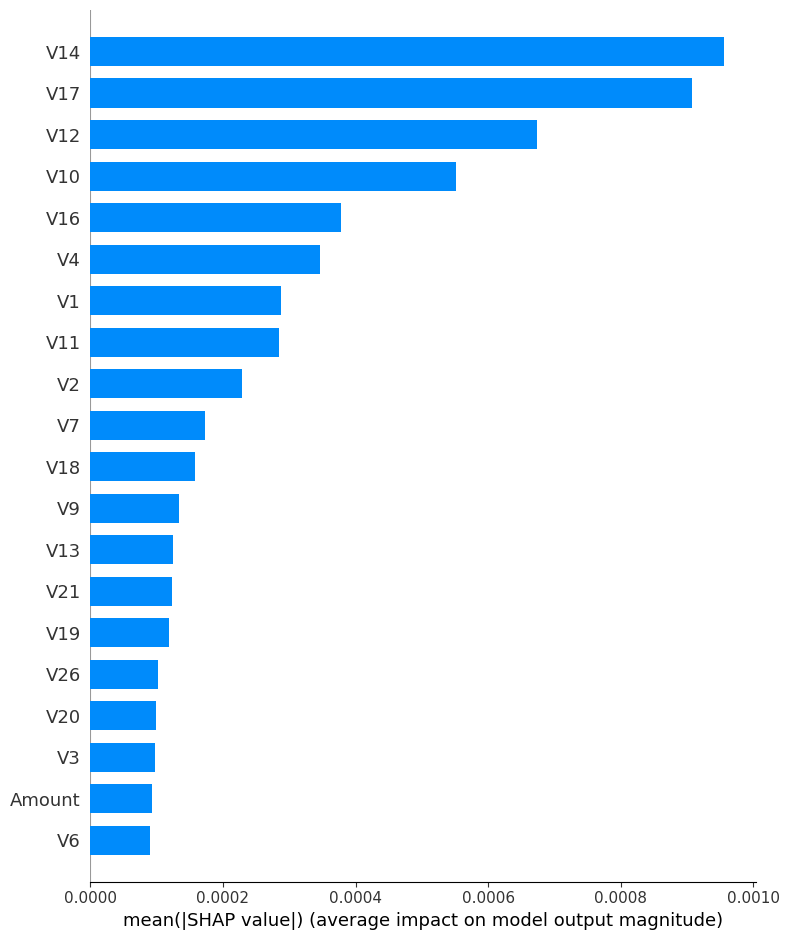

In [20]:
print("\nGenerating SHAP explanation for baseline model...")

# Create SHAP explainer
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

# Handle output shape for both old and new SHAP versions
if isinstance(shap_values, list):
    # Old behavior: list with one array per class
    shap_to_plot = shap_values[1]  # Positive/fraud class
else:
    # New behavior: 3D array (n_samples, n_features, n_classes)
    shap_to_plot = shap_values[:, :, 1]  # Class index 1 = fraud

# Make sure shapes match
print("SHAP values shape to plot:", shap_to_plot.shape)
print("X_test shape:", X_test.shape)

# Summary plot for positive class (fraud)
shap.summary_plot(shap_to_plot, X_test, plot_type="bar")


In [21]:
compliance_report = f"""
CREDIT CARD FRAUD DETECTION - AI SECURITY & PRIVACY AUDIT
--------------------------------------------------------
Timestamp: {audit_log['timestamp']}

Threat Simulation:
- Simulated {audit_log['poisoning_fraction']*100:.1f}% label poisoning to test fraud model robustness.

Model Performance:
- Baseline Accuracy: {audit_log['baseline_metrics']['accuracy']:.4f}
- Privacy-Preserved Accuracy: {audit_log['privacy_preserved_metrics']['accuracy']:.4f}

Security Governance:
- Evaluated model under data poisoning threat scenario.
- Applied simple feature masking ('Amount', 'Time') to enhance privacy.

Transparency:
- SHAP feature importance analysis used to interpret influential features for fraud classification.

Audit Readiness:
- Metrics, confusion matrices, and parameters logged for review.
- Supports compliance with GDPR, PCI DSS, and AI governance best practices.
"""

print(compliance_report)



CREDIT CARD FRAUD DETECTION - AI SECURITY & PRIVACY AUDIT
--------------------------------------------------------
Timestamp: 2025-08-14T10:40:16.061525

Threat Simulation:
- Simulated 2.0% label poisoning to test fraud model robustness.

Model Performance:
- Baseline Accuracy: 0.9994
- Privacy-Preserved Accuracy: 0.9994

Security Governance:
- Evaluated model under data poisoning threat scenario.
- Applied simple feature masking ('Amount', 'Time') to enhance privacy.

Transparency:
- SHAP feature importance analysis used to interpret influential features for fraud classification.

Audit Readiness:
- Metrics, confusion matrices, and parameters logged for review.
- Supports compliance with GDPR, PCI DSS, and AI governance best practices.

